In [2]:

# coding: utf-8

# # Load libraries

# In[1]:
'''
On Bracewell, load these commands below:
module load tensorflow/1.14.0-py36-gpu
module load cuda/9.0.176
module load cudnn/v6
python 3D-FCN2-ECCV-data-Chuong_onroad.py
'''

import re
import cv2
import numpy as np
import os
import datetime
import math
import zedutils
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tqdm import tqdm

from plane_fitting import fitPlane, getInliers, getHorizonLine, track3D_img, track3D_mask, fitPlaneCorr
from utilities import getStereoDisparity
#switch between on road data and off road data
ROOT = '../data/'
WORK_ON = 'both_road' #'on_road' #'off_road' #
NETWORK = '3D-FCN2' #'3D-FCN'
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# # Load data

map1x, map1y, map2x, map2y, mat, Q1 = \
                zedutils.getTransformFromConfig('SN1994.conf', Type='CAM_HD')

Q = np.array([[1, 0, 0, -6.57925000e+02],
             [0, 1, 0, -3.78654000e+02],
             [0, 0, 0, 6.99943000e+02],
             [0, 0, 1/120., 0]])

# In[2]:
def rebin(arr, new_shape):
    '''
    Source: https://scipython.com/blog/binning-a-2d-array-in-numpy/
    '''
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    
    return arr.reshape(shape).mean(-1).mean(1)


def rebin_image2D(arr, bin_size):
    '''
    Modified version of rebin to accept bin_size instead of new_shape
    '''
    shape = (arr.shape[0] // bin_size[0], bin_size[0],
             arr.shape[1] // bin_size[1], bin_size[1])
    return arr.reshape(shape).mean(axis=(-1, 1))


def rebin_image3D(img, bin_size=(2, 2)):
    '''
    Bin images according to bin_size
    '''
    img_bin = np.stack([rebin_image2D(img[:, :, i].astype(np.float32), bin_size) for i in range(img.shape[2])],
                       axis=2)

    return img_bin


def warp_transformation():
    IMAGE_H=100
    IMAGE_W=320
    img = X_train[60][0]
    #img = img[100:240, 0:320]
    src = np.float32([[0, 240], [IMAGE_W, 240], [0, 0], [IMAGE_W, 0]])
    dst = np.float32([[100, 240], [220, 240], [0, 0], [IMAGE_W, 0]])

    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation
    warped_img = cv2.warpPerspective(img, M, (IMAGE_W, 240)) # Image warping
    im1_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(warped_img,cv2.COLOR_BGR2GRAY)
    sz = img.shape
    warp_mode = cv2.MOTION_HOMOGRAPHY
    warp_matrix = np.eye(3, 3, dtype=np.float32)
    number_of_iterations = 5000
    termination_eps = 1e-10
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    (cc, warp_matrix) = cv2.findTransformECC (im2_gray,im1_gray,warp_matrix, warp_mode, criteria)

def load_dataset_path(txt_path):
    p = np.genfromtxt(txt_path, dtype='str')
    return p[:, 1]

def logTransform(c, f):
    g = c * math.log(float(1 + f), math.e)
    return g

def logTransformImage(image, outputMax = 255, inputMax = 255):
    c = 255 / np.log(1 + np.max(image))
    image = image + 1
    image = np.where(image<1, 255, image)
    log_image = c * (np.log(image))

    # Specify the data type so that
    # float value will be converted to int
    log_image = np.array(log_image, dtype = np.uint8)
    return log_image

    
def bird_eye(image, warpMatrix):
    image = image[100:240, 0:320]
    sz = image.shape
    warpped_img = cv2.warpPerspective (image, warpMatrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return warpped_img

def get_bird_eye(pair, mask_gt, ismask):
    im1_c = pair[:, :pair.shape[1]//2, :]
    im2_c = pair[:, pair.shape[1]//2:, :]
    im1_rec = cv2.remap(im1_c, map1x, map1y,
                                        cv2.INTER_CUBIC)
    im2_rec = cv2.remap(im2_c, map2x, map2y,
                        cv2.INTER_CUBIC)
    pair = np.concatenate((im1_rec, im2_rec), axis=1)
    
    leftBGR = pair[:, :pair.shape[1]//2, :]
    rightBGR = pair[:, pair.shape[1]//2:, :] 
    maxDisparity = 32
    disp = getStereoDisparity(pair, dispRange=[0, maxDisparity])
    if 'u' not in globals():
        # inialise these variables
        u, v = np.meshgrid(np.arange(disp.shape[1]),
                            np.arange(disp.shape[0]))
    groundCoefs, mask = fitPlane(u, v, disp, skip=10, infHeight=350)
    d = groundCoefs[0]*u + groundCoefs[1]*v + groundCoefs[2]
    d[d < 0] = 0
    mask = getInliers(u, v, d, disp, tolerance=np.array([1, 0.05]))
    mask[:400, :] = False

    mask2 = np.logical_not(mask)
    disp2 = np.copy(disp)
    disp2[mask2] = 0
    disp3 = np.copy(disp)
    disp3[mask] = 0
    
    infHeight = 400
    w, h, dmax = 1.0, 1.0, 1.0
    v0 = h*infHeight/d.shape[0] #
    u0, v0, d0 = [w/2.0, v0, 0.0]
    u1, v1, d1 = [w/2.0, h, dmax]
    u2, v2, d2 = [0.0, v0, 0.0]
    a = -d1*(v2-v0)/u0/(v1-v0)
    b = d1/(v1-v0)
    c = d1*(v2-2.0*v0)/(v1-v0)

    x0 = np.array([a, b, c])

    groundCoefs2 = fitPlaneCorr([groundCoefs[0], groundCoefs[1], groundCoefs[2]/1000], leftBGR, rightBGR, mask)
    groundCoefs2[2] *= 1000
    #print(groundCoefs, groundCoefs2)
    ROIXZ=[-10., 10., 0.5, 20.]
    if ismask:
        return track3D_mask(mask_gt[:,:,0], groundCoefs2, disp, Q, ROIXZ)
    else:

        return track3D_img(leftBGR, groundCoefs2, disp, Q, ROIXZ)
    
def get_hmatrix():
    pair = cv2.imread('../Dataset/video_off_road/img_000000500.ppm')
    #pair = logTransformImage(pair)
    #load only left frame.
    #frame_left = pair.copy()
    #remap
    #frame_left_rec = np.uint8(frame_left) #cv2.remap(frame_left, map1x, map1y, cv2.INTER_CUBIC)
    #resize
    #frame_left_rec = np.uint8(rebin_image3D(frame_left_rec, resize_by))
    leftBGR = pair[:, :pair.shape[1]//2, :]
    origin1 = [491, 714]
    origin2 = [1251, 717]
    origin3 = [554, 545]
    origin4 = [873, 512]
    corner_points_array = np.float32([origin1,origin2,origin3,origin4])
    birdeye1 = [585,620]
    birdeye2 = [810,625]
    birdeye3 = [578,514]
    birdeye4 = [778,485]
    img_params = np.float32([birdeye1,birdeye2,birdeye3,birdeye4])
    matrix = cv2.getPerspectiveTransform(corner_points_array,img_params)
    return matrix

def getECCTransformation():
    pair = cv2.imread('../Dataset/video_off_road/img_000000500.ppm')
    matrix = get_hmatrix()
    leftBGR = pair[:, :pair.shape[1]//2, :]
    rightBGR = pair[:, pair.shape[1]//2:, :] 
    #img_transformed_l = cv2.warpPerspective(leftBGR,matrix,(1280,720))
    #img_transformed_r = cv2.warpPerspective(rightBGR,matrix,(1280,720))
    img_transformed_l = cv2.warpPerspective(leftBGR,matrix,(647/2,189))
    img_transformed_r = cv2.warpPerspective(rightBGR,matrix,(647/2,189))
    leftBGR_gray = cv2.cvtColor(img_transformed_l,cv2.COLOR_BGR2GRAY)
    rightBGR_gray  = cv2.cvtColor(img_transformed_r,cv2.COLOR_BGR2GRAY)
    warp_matrix = np.eye(3, 3, dtype=np.float32)
    warp_mode = cv2.MOTION_HOMOGRAPHY
    number_of_iterations = 10000
    termination_eps = 1e-10
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    (cc, warp_matrix) = cv2.findTransformECC (rightBGR_gray,leftBGR_gray,warp_matrix, warp_mode, criteria)
    return warp_matrix
    

    
def load_data_bothroad(img_folder, txt_path, resize_by, num_frames=8, skipping=False):
    # load ZED camera config and
    # obtain stereo rectification maps, camera matrix and Q matrix
    # default is skipping to
    map1x, map1y, map2x, map2y, mat, Q = zedutils.getTransformFromConfig('SN1994.conf', Type='CAM_HD')
    stereo = cv2.StereoSGBM_create(0, 32, 19, speckleWindowSize=100, speckleRange=2)

    X = []
    Y = []

    mask_file_names = load_dataset_path(txt_path)

    for mask_file_name in tqdm(mask_file_names):
        file_num = int(re.findall('\d+', mask_file_name )[0])
        if 'on_road' in mask_file_name:
            fname = '../Dataset/masks/on_road/left_mask_%09d.png' % (file_num)
            img_folder = '../Dataset/video_on_road/'
        else:
            fname = '../Dataset/masks/off_road/left_mask_%09d.png' % (file_num)
            img_folder = '../Dataset/video_off_road/'
        mask = cv2.imread(fname, 0)
        if skipping:
            mask = mask[::resize_by[0], ::resize_by[1]]
        else:
            mask = np.uint8(rebin_image2D(mask, resize_by))
            mask[mask>127] = 255
            mask[mask<=127] = 0
        #load mask to Y
        Y.append(mask.flatten())
        #load num_frames before truth mask.
        video = []
        i = 0
        for j in range(file_num-num_frames+1,file_num+1):
            image_file_name = os.path.join(img_folder, 'img_%09d.ppm' % j)
            #load pair
            pair = cv2.imread(image_file_name)
            #load only left frame.
            frame_left = pair[:,:pair.shape[1]//2,:].copy()
            #remap
            frame_left_rec = frame_left #cv2.remap(frame_left, map1x, map1y, cv2.INTER_CUBIC)
            #frame_left_rec = logTransformImage(frame_left)
            #resize
            if skipping:
                frame_left_rec = frame_left_rec[::resize_by[0], ::resize_by[1], :]
            else: # binning
                frame_left_rec = np.uint8(rebin_image3D(frame_left_rec, resize_by))

            #images form a video
            video.append(frame_left_rec)

        X.append(video)

    return np.array(X),np.array(Y)# In[5]:


# In[6]:


#One hot encoding for each pixel
def one_hot(Y):
    result = []
    for i in tqdm(range(len(Y))):
        img_array = []
        for j in range(len(Y[i])):
            e = Y[i][j]
            if e > 127:
                img_array.append(np.array([0,1]))
            else:
                img_array.append(np.array([1,0]))
        result.append(img_array)
    return np.array(result)


outfile = os.path.join('../Dataset/'+WORK_ON+'_data.npz')
if os.path.exists(outfile)==False:
    print('Read '+'../Dataset/'+WORK_ON+'_train.txt')
    X_train,y_train = load_data_bothroad('../Dataset/video_'+WORK_ON, '../Dataset/'+WORK_ON+'_train.txt', resize_by=(3,4))
    print('Read '+'../Dataset/'+WORK_ON+'_test.txt')
    X_test, y_test  = load_data_bothroad('../Dataset/video_'+WORK_ON, '../Dataset/'+WORK_ON+'_test.txt', resize_by=(3,4))
    print('Convert to one hot')
    y_train = one_hot(y_train)
    y_test  = one_hot(y_test)
    print('Saved precomputed data to %s' % outfile)
    np.savez(outfile, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
else:
    print('Load precomputed data file %s' % outfile)
    npzfile = np.load(outfile)
    X_train = npzfile['X_train']
    y_train = npzfile['y_train']
    X_test = npzfile['X_test']
    y_test = npzfile['y_test']

image_shape = X_train.shape[2:]
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)
print('X_test.shape', X_test.shape)
print('y_test.shape', y_test.shape)

# In[8]:


#shows a random video with its mask
def show_data(X, Y_true, Y_pred = None):
    #de-one-hot
    Y_true = np.array(Y_true.argmax(axis=2) * 255,dtype=np.uint8)
    #random show a pair of video & mask
    n = np.random.randint(X.shape[0])
    images,msk = X[n],Y_true[n]
    for i,image in enumerate(images):
        cv2.putText(image,
                    str(i),
                    (10, image.shape[0]-15),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255))
        cv2.imshow("images",image)
        if i == len(images) - 1:
            cv2.imshow("true_mask",msk.reshape(image_shape[0:2]))
            if Y_pred is not None:
                Y_pred = np.array(Y_pred.argmax(axis=2) * 255,dtype=np.uint8)
                msk_pred = Y_pred[n]
                cv2.imshow("pred_mask", msk_pred.reshape(image_shape[0:2]))
        cv2.waitKey(0)
    cv2.destroyAllWindows()

#show_data(X_train,y_train)

# choose GPU
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
#os.environ["CUDA_VISIBLE_DEVICES"]="1";  

# # Load Model

# In[9]:

from tensorflow.keras import backend
from tensorflow.keras.models import *
from tensorflow.keras.layers import *


n_classes = 2
input_shape = X_train.shape[1:]
img_input = Input(shape=(input_shape),name='input')
kernel_size = (3,3,3)
pool_size = (2,2,2)
#kernel_size = (3,3)
#pool_size = (2,2)

#strides_size = (2,2,2)
filter_size = 64


# In[10]:

# In[10]:
def conv3d_bn(x, filters, num_row, num_col, num_z, padding='same', strides=(1, 1, 1), activation='relu', name=None):

    x = Conv3D(filters, (num_row, num_col, num_z), strides=strides, padding=padding, use_bias=False)(x)
    x = tfa.layers.GroupNormalization(groups=32, axis=4)(x)

    if(activation==None):
        return x

    x = Activation(activation, name=name)(x)
    return x


def ResBlock(U, inp):
    shortcut = inp
    shortcut = conv3d_bn(shortcut, U, 1, 1, 1, activation=None, padding='same')
    conv3x3 = conv3d_bn(inp, U, 3, 3, 3, activation='relu', padding='same')
    conv5x5 = conv3d_bn(conv3x3, U, 3, 3, 3, activation='relu', padding='same')
    #out = BatchNormalization(axis=4)(conv5x5)
    out = tfa.layers.GroupNormalization(groups=32, axis=4)(conv5x5)
    
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = tfa.layers.GroupNormalization(groups=32, axis=4)(out)

    return out
    
def CSPRes(U, inp, pool_size):
    part1 = inp
    part1 = conv3d_bn(part1, U//2,  1, 1, 1, activation='relu', padding='same')
    par1 = tfa.layers.GroupNormalization(groups=32, axis=4)(part1)
    part2 = ResBlock(U//2, inp)
    
    out = tf.keras.layers.concatenate([part1, part2], axis=4)
    out = tfa.layers.GroupNormalization(groups=32, axis=4)(out)
    return out
    
    

def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    shortcut = inp
    shortcut = conv3d_bn(shortcut, filters , 1, 1, 1, activation=None, padding='same')

    out = conv3d_bn(inp, filters, 3, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = tfa.layers.GroupNormalization(groups=32, axis=4)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv3d_bn(shortcut, filters , 1, 1, 1, activation=None, padding='same')

        out = conv3d_bn(out, filters, 3, 3, 3, activation='relu', padding='same')        

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = tfa.layers.GroupNormalization(groups=32, axis=4)(out)


    return out

def make_model(input_shape, n_classes, filter_size, kernel_size, pool_size):
    #This code structure is based on Image Segmentation Keras by divamgupta.
    #https://github.com/divamgupta/image-segmentation-keras
    img_input = Input(shape=(input_shape),name='input')
    #Block1
    part1, part2 = tf.split(img_input, 2, 1)
    part1 = ResBlock(filter_size, part1) 
    part2 = conv3d_bn(part2, filter_size, 3, 3, 3, padding='same', strides=(1, 1, 1), activation='relu', name=None)
    x = concatenate([part1, part2],axis=1)
    x = tfa.layers.GroupNormalization(groups=32)(x)
    #x = BatchNormalization(name='bn1')(x)
    x = MaxPooling3D(pool_size = pool_size, name = 'block1_pool1')(x)
    part1, part2 = tf.split(x, 2, 1)
    part1 = ResPath(filter_size, 2, part1)
    part2 = conv3d_bn(part2, filter_size, 3, 3, 3, padding='same', strides=(1, 1, 1), activation='relu', name=None)
    f1 = concatenate([part1,part2],axis=1)
    #Block2
    part1, part2 = tf.split(x, 2, 1)
    part1 = ResBlock(filter_size, part1)
    x = concatenate([part1,part2],axis=1)
    
    x = tfa.layers.GroupNormalization(groups=32)(x)
    x = MaxPooling3D(pool_size = pool_size, name = 'block2_pool1')(x)
    
    part1, part2 = tf.split(x, 2, 1)
    part1 = ResPath(filter_size*2,1, part1)
    part2 = conv3d_bn(part2, filter_size*2, 3, 3, 3, padding='same', strides=(1, 1, 1), activation='relu', name=None)
    f2 = concatenate([part1,part2],axis=1)
    #Block3
#     x = CSPRes(filter_size*4, x, pool_size) 
#     x = tfa.layers.GroupNormalization(groups=32)(x)
#     x = MaxPooling3D(pool_size = pool_size, name = 'block3_pool1')(x)
    part1, part2 = tf.split(x, 2, 1)
    part1 = ResBlock(filter_size, part1)
    x = concatenate([part1,part2],axis=1)
    x = tfa.layers.GroupNormalization(groups=32)(x)
    x = MaxPooling3D(pool_size = pool_size, name = 'block3_pool1')(x)
    f3 = x

    f3_shape = Model(img_input,f3).output_shape
    o = f3
    o = Reshape(f3_shape[2:],name='reshape1')(o) # remove the first dimension as it equals 1
    #Extract feature
    o = Conv2D(filters = 2048, kernel_size = (7,7), activation='relu', padding = 'same', data_format = 'channels_last',name='increase_conv1')(o)
    o = Dropout(0.5,name='drop1')(o)
    o = Conv2D(filters = 2048, kernel_size = (1,1), activation='relu', padding = 'same', data_format = 'channels_last',name='increase_conv2')(o)
    o = Dropout(0.5,name='drop2')(o)
    #Predict layer
    o = Conv2D(n_classes, (1,1),data_format='channels_last',name='pred_conv1')(o)

    #Deconv by 2 for adding.
    o = Conv2DTranspose(n_classes, kernel_size=(32,32), strides=(2,2), padding='same', use_bias=False, data_format='channels_last',name='Deconv1')(o)
    #Features from f2 layer
    o1 = f2
   
    o1 = AveragePooling3D(pool_size = (2,1,1))(o1)
  
    o1 = Reshape((60,80,128))(o1)
    #print(o1.shape)
    ##############################
    #Respath block
    #o1 = ResPath(n_classes, 2, o1)
    o1 = Conv2D(n_classes, (1,1),data_format='channels_last',name='pred_conv2')(o1)
    
    o = concatenate([o,o1],axis=3)
    o = Conv2D(n_classes, (1,1),data_format='channels_last',name='concat1_conv')(o)
    #Deconv by 4->2
    o = Conv2DTranspose(n_classes, kernel_size=(32,32), strides=(2,2), padding='same', use_bias=False, data_format='channels_last',name='Deconv2')(o)

    #feature from f1 layer
    o2 = f1
    #print(o2.shape)
    #o2 = Lambda(lambda x:x[:,-1,:,:,:], name='select2')(o2) #use last channel as our prediction is final frame's mask
    o2 = AveragePooling3D(pool_size = (4,1,1))(o2)
    #print(o2.shape)
    o2 = Reshape((120,160,64))(o2)
    o2 = Conv2D(n_classes, (1,1),data_format='channels_last',name='pred_conv3')(o2)
    #sum them together
    o = concatenate([o,o2],axis=3)
    o = Conv2D(n_classes, (1,1),data_format='channels_last',name='concat2_conv')(o)
    #Deconv by 2
    o = Conv2DTranspose(n_classes, kernel_size=(32,32), strides=(2,2), padding='same', use_bias=False, data_format='channels_last',name='Deconv3')(o)

    #softmax
    o = Activation('softmax',name='softmax')(o)

    o_shape = Model(img_input, o).output_shape

    outputHeight = o_shape[1]
    outputWidth = o_shape[2]

    o_flatten = Reshape((outputHeight*outputWidth, -1),name='reshape_out')(o)

    model = Model(img_input, o_flatten)
    return model


# In[11]:

model = make_model(input_shape, n_classes, filter_size, kernel_size, pool_size)
model.summary(line_length=120)


# In[12]:

opt='SGD' # 'Adam' doesn't work
loss='categorical_crossentropy'
metrics=['accuracy']


def focal_loss(gamma=2., alpha=.25):
    '''
    Keras Focal Loss from https://github.com/mkocabas/focal-loss-keras
    Usage: model_prn.compile(optimizer=optimizer, loss=[focal_loss(alpha=.25, gamma=2)])
    '''
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
       # print('pt_1: ', tf.reduce_min(pt_1))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
       # print('pt_0: ', tf.reduce_min(pt_0))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

#from tensorflow.python.ops import array_ops
#def focal_loss(prediction_tensor, target_tensor):
#    '''
#    Focal loss from https://github.com/Cow911/SingleImageWaterHazardDetectionWithRAU/blob/master/source/TensorflowUtils.py
#    '''
#    alpha1=1
#    alpha2=1
#    gamma=2
#    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
#    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
#    pos_p_sub = array_ops.where(target_tensor >= sigmoid_p, target_tensor - sigmoid_p, zeros)
#    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
#    per_entry_cross_ent = - alpha1 * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
#                          - alpha2 * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
#    return tf.reduce_mean(per_entry_cross_ent)

# In[16]:

#import tensorflow as tf
#from tensorflow.keras.initializers import glorot_uniform  # Or your initializer of choice
#import tensorflow.keras.backend as K
#initial_weights = model.get_weights()



Read ../Dataset/both_road_train.txt


100%|████████████████████████████████████████████████████████████████████████████████| 802/802 [02:11<00:00,  6.08it/s]


Read ../Dataset/both_road_test.txt


100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [00:30<00:00,  5.98it/s]


Convert to one hot


100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [01:04<00:00,  2.83it/s]


Saved precomputed data to ../Dataset/both_road_data.npz
X_train.shape (802, 8, 240, 320, 3)
y_train.shape (802, 76800, 2)
X_test.shape (183, 8, 240, 320, 3)
y_test.shape (183, 76800, 2)
Model: "model_5"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input (InputLayer)                     [(None, 8, 240, 320, 3)]   0                                                     
________________________________________________________________________________________________________________________
tf.split_5 (TFOpLambda)                [(None, 4, 240, 320, 3), ( 0             input[0][0]                             
________________________________________________________________________________________________________________________
conv3d_19 (Conv3D)                     (None, 4, 240, 320, 64)    5184 

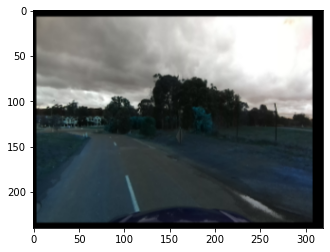

In [3]:
plt.imshow(X_train[40][0])

################################################
Test number 0
Epoch 1/80
272/272 [==============================] - 74s 255ms/step - loss: 0.0163 - accuracy: 0.9613 - val_loss: 0.0061 - val_accuracy: 0.9900
Epoch 2/80
272/272 [==============================] - 66s 244ms/step - loss: 0.0058 - accuracy: 0.9911 - val_loss: 0.0053 - val_accuracy: 0.9904
Epoch 3/80
272/272 [==============================] - 67s 245ms/step - loss: 0.0053 - accuracy: 0.9907 - val_loss: 0.0049 - val_accuracy: 0.9907
Epoch 4/80
272/272 [==============================] - 65s 239ms/step - loss: 0.0048 - accuracy: 0.9913 - val_loss: 0.0048 - val_accuracy: 0.9900
Epoch 5/80
272/272 [==============================] - 66s 244ms/step - loss: 0.0045 - accuracy: 0.9911 - val_loss: 0.0044 - val_accuracy: 0.9909
Epoch 6/80
272/272 [==============================] - 68s 250ms/step - loss: 0.0043 - accuracy: 0.9915 - val_loss: 0.0046 - val_accuracy: 0.9895
Epoch 7/80
272/272 [==============================] - 70s 257ms/ste

Epoch 57/80
272/272 [==============================] - 66s 242ms/step - loss: 0.0021 - accuracy: 0.9947 - val_loss: 0.0025 - val_accuracy: 0.9942
Epoch 58/80
272/272 [==============================] - 66s 242ms/step - loss: 0.0020 - accuracy: 0.9949 - val_loss: 0.0025 - val_accuracy: 0.9942
Epoch 59/80
272/272 [==============================] - 66s 242ms/step - loss: 0.0020 - accuracy: 0.9948 - val_loss: 0.0026 - val_accuracy: 0.9942
Epoch 60/80
272/272 [==============================] - 66s 242ms/step - loss: 0.0023 - accuracy: 0.9942 - val_loss: 0.0027 - val_accuracy: 0.9933
Epoch 61/80
272/272 [==============================] - 66s 242ms/step - loss: 0.0020 - accuracy: 0.9947 - val_loss: 0.0025 - val_accuracy: 0.9944
Epoch 62/80
272/272 [==============================] - 66s 242ms/step - loss: 0.0021 - accuracy: 0.9945 - val_loss: 0.0026 - val_accuracy: 0.9939
Epoch 63/80
272/272 [==============================] - 66s 242ms/step - loss: 0.0020 - accuracy: 0.9949 - val_loss: 0.0025 -

(MainThread) title position was updated manually, not adjusting


Saved model to 2DFCN2ECCV.h5


(MainThread) title position was updated manually, not adjusting
(MainThread) title position was updated manually, not adjusting
(MainThread) title position was updated manually, not adjusting


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6461277
           1       0.78      0.62      0.69     66723

    accuracy                           0.99   6528000
   macro avg       0.89      0.81      0.84   6528000
weighted avg       0.99      0.99      0.99   6528000



(MainThread) title position was updated manually, not adjusting
(MainThread) title position was updated manually, not adjusting
(MainThread) title position was updated manually, not adjusting
(MainThread) title position was updated manually, not adjusting


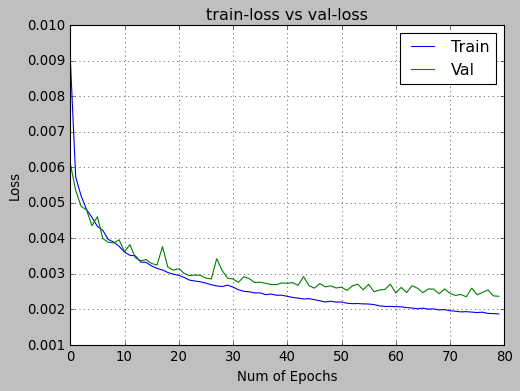

(MainThread) title position was updated manually, not adjusting
(MainThread) title position was updated manually, not adjusting
(MainThread) title position was updated manually, not adjusting
(MainThread) title position was updated manually, not adjusting


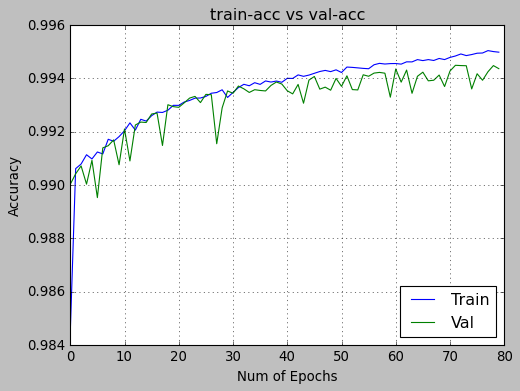

In [5]:
import datetime
import json
import os

no_tests = 1
epoch_num = 80 # 80 #18 #240
loss_name = 'focal' # 'loss'
for i in range(no_tests):
    print('################################################')
    print('Test number %d' % i)
    backend.clear_session()
    model = make_model(input_shape, n_classes, filter_size, kernel_size, pool_size) # reset model each time
    trained_weights = outfile = os.path.join('2DFCN2ECCV.h5')
    if os.path.exists(outfile):
        model.load_weights(trained_weights)
        print('Load trained weights')
    if loss_name.lower() == 'loss':
        model.compile(optimizer=opt, loss=loss, metrics=metrics)
    elif loss_name.lower() == 'focal':
        model.compile(optimizer=opt, loss=focal_loss(alpha=.25, gamma=2), metrics=metrics)
#        model.compile(optimizer=opt, loss=focal_loss, metrics=metrics)

    history = model.fit(X_train, y_train, epochs= epoch_num, validation_data=(X_test,y_test),verbose = 1,batch_size=1)


    # In[24]:


    
    currentDT = datetime.datetime.now()
    dt_str = currentDT.strftime("%Y-%m-%d_%H-%M-%S")
    #model_fname = '%s_%s_%s_%s.h5' % (NETWORK, WORK_ON, loss_name, dt_str)
    model_fname = '2DFCN2ECCV.h5'
    # save model
    model.save(model_fname)
    print('Saved model to ' + model_fname)
    # load model
    #model = load_model(model_fname)


    # In[17]:


    train_loss=history.history['loss']
    val_loss=history.history['val_loss']
    train_acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    xc=range(epoch_num)

    
    out_dic = {'train_loss': [str(num) for num in train_loss],
               'val_loss': [str(num) for num in val_loss],
               'train_acc': [str(num) for num in train_acc],
               'val_acc': [str(num) for num in val_acc],
               'epoch': [int(num) for num in xc]
               }
    history_fname = '%s_%s_%s_%s_history.json' % (NETWORK, WORK_ON, loss_name, dt_str)
    with open(history_fname, 'w') as fp:
        fp.write(json.dumps(out_dic, indent=4, sort_keys=True))

    fig = plt.figure(1,figsize=(7,5))
    fig.clf()
    plt.plot(xc,train_loss)
    plt.plot(xc,val_loss)
    plt.xlabel('Num of Epochs')
    plt.ylabel('Loss')
    plt.title('train-loss vs val-loss')
    plt.grid(True)
    plt.legend(['Train','Val'])
    plt.style.use(['classic'])
#    plt.xlim([0, epoch_num])
#    plt.ylim([0, 1])
    fig1_fname = '%s_%s_%s_%s_fig1.png' % (NETWORK, WORK_ON, loss_name, dt_str)
    plt.savefig(fig1_fname, dpi=300)

    fig2 = plt.figure(2,figsize=(7,5))
    fig2.clf()
    plt.plot(xc,train_acc)
    plt.plot(xc,val_acc)
    plt.xlabel('Num of Epochs')
    plt.ylabel('Accuracy')
    plt.title('train-acc vs val-acc')
    plt.grid(True)
    plt.legend(['Train','Val'],loc=4)
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])
#    plt.xlim([0, epoch_num])
#    plt.ylim([0, 1])
    fig2_fname = '%s_%s_%s_%s_fig2.png' % (NETWORK, WORK_ON, loss_name, dt_str)
    plt.savefig(fig2_fname, dpi=300)


    # # Evaluation

    # In[25]:


    prediction = model.predict(X_test,batch_size = 1)

    from sklearn.metrics import classification_report
    prediction.shape
    print(classification_report(y_test.argmax(axis=2).flatten(),prediction.argmax(axis=2).flatten()))
    report_fname = '%s_%s_%s_%s_report.txt' % (NETWORK, WORK_ON, loss_name, dt_str)
    with open(report_fname, 'w') as fp:
        fp.write(classification_report(y_test.argmax(axis=2).flatten(),prediction.argmax(axis=2).flatten()))


    # In[26]:


    #Shows a random pred-true-image pair.
    #show_data(X_test,y_test,prediction)


    # In[33]:


    #Save compare pairs to folders
    def save_predictions(X,Y_true,Y_pred,path):
        #de-one-hot
        Y_true = np.array(Y_true.argmax(axis=2) * 255,dtype=np.uint8)
        Y_pred = np.array(Y_pred.argmax(axis=2) * 255,dtype=np.uint8)
        for n in range(len(X_test)):
            images,msk = X[n],Y_true[n]
            msk_pred = Y_pred[n]
            cv2.imwrite(path + str(n)+'_img.jpg',images[-1])
            cv2.imwrite(path + str(n)+'_true.jpg',msk.reshape(image_shape[0:2]))
            cv2.imwrite(path + str(n)+'_pred.jpg',msk_pred.reshape(image_shape[0:2]))
    
    os.makedirs('Dataset/result_pair_'+NETWORK+'_'+WORK_ON+'/'+dt_str+'/')
    save_predictions(X_test,y_test,prediction, 'Dataset/result_pair_'+NETWORK+'_'+WORK_ON+'/'+dt_str+'/')


In [17]:
 model.load_weights('2DFCN2ECCV.h5')

In [15]:
%%time
prediction = model.predict(X_test,batch_size = 1)
from sklearn.metrics import classification_report
prediction.shape
print(classification_report(y_test.argmax(axis=2).flatten(),prediction.argmax(axis=2).flatten()))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00   7400298
           1       0.89      0.68      0.77    126102

    accuracy                           0.99   7526400
   macro avg       0.94      0.84      0.88   7526400
weighted avg       0.99      0.99      0.99   7526400

Wall time: 16.7 s


In [ ]:
def make_model(input_shape, n_classes, filter_size, kernel_size, pool_size):
    #This code structure is based on Image Segmentation Keras by divamgupta.
    #https://github.com/divamgupta/image-segmentation-keras
    img_input = Input(shape=(input_shape),name='input')
    #Block1
    part1, part2 = tf.split(img_input, 2, 3)
    part1 = ResBlock(filter_size, part1) 
    part2 = conv3d_bn(part2, filter_size, 3, 3, 3, padding='same', strides=(1, 1, 1), activation='relu', name=None)
    x = concatenate([part1, part2],axis=3)
    x = tfa.layers.GroupNormalization(groups=32)(x)
    #x = BatchNormalization(name='bn1')(x)
    x = MaxPooling3D(pool_size = pool_size, name = 'block1_pool1')(x)
    part1, part2 = tf.split(x, 2, 3)
    part1 = ResPath(filter_size, 2, part1)
    part2 = conv3d_bn(part2, filter_size, 3, 3, 3, padding='same', strides=(1, 1, 1), activation='relu', name=None)
    f1 = concatenate([part1,part2],axis=3)
    #Block2
    part1, part2 = tf.split(x, 2, 3)
    part1 = ResBlock(filter_size, part1)
    x = concatenate([part1,part2],axis=3)
    
    x = tfa.layers.GroupNormalization(groups=32)(x)
    x = MaxPooling3D(pool_size = pool_size, name = 'block2_pool1')(x)
    
    part1, part2 = tf.split(x, 2, 3)
    part1 = ResPath(filter_size*2,1, part1)
    part2 = conv3d_bn(part2, filter_size*2, 3, 3, 3, padding='same', strides=(1, 1, 1), activation='relu', name=None)
    f2 = concatenate([part1,part2],axis=3)
    #Block3
#     x = CSPRes(filter_size*4, x, pool_size) 
#     x = tfa.layers.GroupNormalization(groups=32)(x)
#     x = MaxPooling3D(pool_size = pool_size, name = 'block3_pool1')(x)
    part1, part2 = tf.split(x, 2, 3)
    part1 = ResBlock(filter_size, part1)
    x = concatenate([part1,part2],axis=3)
    x = tfa.layers.GroupNormalization(groups=32)(x)
    x = MaxPooling3D(pool_size = pool_size, name = 'block3_pool1')(x)
    f3 = x

    f3_shape = Model(img_input,f3).output_shape
    o = f3
    o = Reshape(f3_shape[2:],name='reshape1')(o) # remove the first dimension as it equals 1
    #Extract feature
    o = Conv2D(filters = 2048, kernel_size = (7,7), activation='relu', padding = 'same', data_format = 'channels_last',name='increase_conv1')(o)
    o = Dropout(0.5,name='drop1')(o)
    o = Conv2D(filters = 2048, kernel_size = (1,1), activation='relu', padding = 'same', data_format = 'channels_last',name='increase_conv2')(o)
    o = Dropout(0.5,name='drop2')(o)
    #Predict layer
    o = Conv2D(n_classes, (1,1),data_format='channels_last',name='pred_conv1')(o)

    #Deconv by 2 for adding.
    o = Conv2DTranspose(n_classes, kernel_size=(32,32), strides=(2,2), padding='same', use_bias=False, data_format='channels_last',name='Deconv1')(o)
    #Features from f2 layer
    o1 = f2
   
    o1 = AveragePooling3D(pool_size = (2,1,1))(o1)
  
    o1 = Reshape((60,80,128))(o1)
    #print(o1.shape)
    ##############################
    #Respath block
    #o1 = ResPath(n_classes, 2, o1)
    o1 = Conv2D(n_classes, (1,1),data_format='channels_last',name='pred_conv2')(o1)
    
    o = concatenate([o,o1],axis=3)
    o = Conv2D(n_classes, (1,1),data_format='channels_last',name='concat1_conv')(o)
    #Deconv by 4->2
    o = Conv2DTranspose(n_classes, kernel_size=(32,32), strides=(2,2), padding='same', use_bias=False, data_format='channels_last',name='Deconv2')(o)

    #feature from f1 layer
    o2 = f1
    #print(o2.shape)
    #o2 = Lambda(lambda x:x[:,-1,:,:,:], name='select2')(o2) #use last channel as our prediction is final frame's mask
    o2 = AveragePooling3D(pool_size = (4,1,1))(o2)
    #print(o2.shape)
    o2 = Reshape((120,160,64))(o2)
    o2 = Conv2D(n_classes, (1,1),data_format='channels_last',name='pred_conv3')(o2)
    #sum them together
    o = concatenate([o,o2],axis=3)
    o = Conv2D(n_classes, (1,1),data_format='channels_last',name='concat2_conv')(o)
    #Deconv by 2
    o = Conv2DTranspose(n_classes, kernel_size=(32,32), strides=(2,2), padding='same', use_bias=False, data_format='channels_last',name='Deconv3')(o)

    #softmax
    o = Activation('softmax',name='softmax')(o)

    o_shape = Model(img_input, o).output_shape

    outputHeight = o_shape[1]
    outputWidth = o_shape[2]

    o_flatten = Reshape((outputHeight*outputWidth, -1),name='reshape_out')(o)

    model = Model(img_input, o_flatten)
    return model